In [ ]:
import numpy as np

def correlation_two_devices(distance: float, rho: float = 7.0, U: float = 20.0) -> np.ndarray:
    if rho == 0:
        p = 1.0 if distance == 0 else 0.0
    else:
        p = np.maximum(
            (np.exp(-distance / rho) - np.exp(-U / rho)) / (1.0 - np.exp(-U / rho)),
            0.0,
        )
    return np.array([[1.0, p], [p, 1.0]], dtype=float)


def anc_two_devices(distance, alpha = 1.0, beta = 2.2, rho = 7.0, U = 20.0) -> np.ndarray:
    C = correlation_two_devices(distance, rho=rho, U=U)
    return alpha * (beta * np.eye(2) - C)

def sic_two_devices(distance, alpha = 1.0, beta = 2.2, rho = 7.0, U = 20.0) -> np.ndarray:
    C = correlation_two_devices(distance, rho=rho, U=U)
    return alpha * np.linalg.pinv(C)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def truncated_bvn_first_quadrant_pdf_grid(Omega, gmax=3.5, grid=250):
    eigs = np.linalg.eigvalsh(Omega)
    if np.any(eigs <= 0):
        raise ValueError(f"Ω not PD; eigs={eigs}")
    Sigma = np.linalg.inv(Omega)
    rho = Sigma[0,1] / np.sqrt(Sigma[0,0]*Sigma[1,1])
    mass_pp = 0.25 + np.arcsin(rho)/(2*np.pi)        # P(X≥0,Y≥0)
    base = np.sqrt(np.linalg.det(Omega)) / (2*np.pi) # untruncated normalizer for N=2
    g = np.linspace(0, gmax, grid)
    G1, G2 = np.meshgrid(g, g)
    Q = Omega[0,0]*G1**2 + 2*Omega[0,1]*G1*G2 + Omega[1,1]*G2**2
    Z = (base / mass_pp) * np.exp(-0.5*Q)            # properly normalized on first quadrant
    return G1, G2, Z, float(rho), float(mass_pp)

def plot_half_gaussian_vs_distance(distances, alpha=1.0, beta=2.2, rho=7.0, U=20.0, gmax=3.5):
    fig, axes = plt.subplots(1, len(distances), figsize=(4.6*len(distances), 4.2), constrained_layout=True)
    axes = [axes] if len(distances)==1 else axes
    for ax, d in zip(axes, distances):
        Omega = sic_two_devices(d, alpha=alpha, beta=beta, rho=rho, U=U)
        G1, G2, Z, r, mpp = truncated_bvn_first_quadrant_pdf_grid(Omega, gmax=gmax)
        cs = ax.contourf(G1, G2, Z, levels=25)
        ax.set_title(rf"$d={d:g}$, $\rho={r:.2f}$")
        ax.set_xlabel(r"$\gamma_1$"); ax.set_ylabel(r"$\gamma_2$")
        fig.colorbar(cs, ax=ax, shrink=0.85, label="pdf")
    fig.suptitle("Half-Gaussian from Ω = α(βI − C(d))")
    plt.show()


/tmp/ipython-input-2274837894.py:10: RuntimeWarning: invalid value encountered in arcsin
  mass_pp = 0.25 + np.arcsin(rho)/(2*np.pi)        # P(X≥0,Y≥0)
/tmp/ipython-input-2274837894.py:11: RuntimeWarning: invalid value encountered in sqrt
  base = np.sqrt(np.linalg.det(Omega)) / (2*np.pi) # untruncated normalizer for N=2


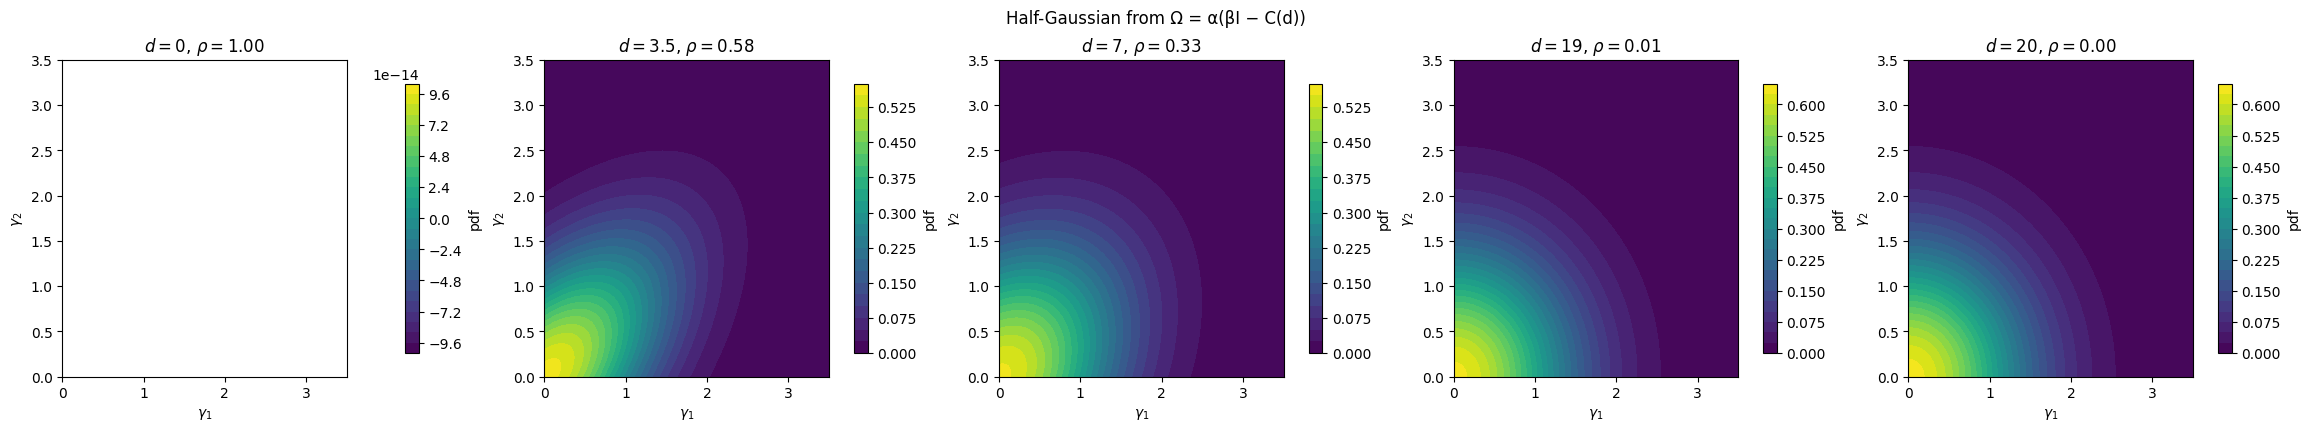

In [ ]:
plot_half_gaussian_vs_distance([0, 3.5, 7, 19, 20], alpha=1.0, beta=2.2, rho=7.0, U=20.0)

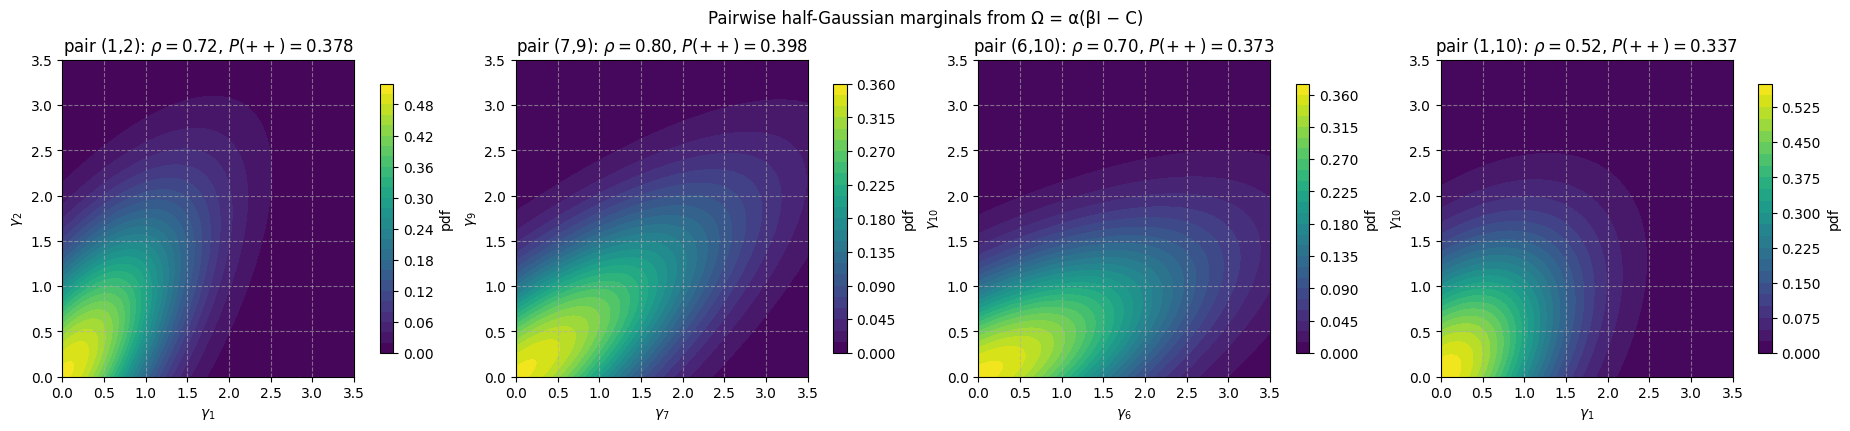

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Build C from locations (no stabilizations) ---
def build_correlation_matrix_anc(loc: np.ndarray, rho: float = 7.0, U: float = 20.0) -> np.ndarray:
    N = loc.shape[0]
    if rho == 0:
        return np.eye(N)
    D = np.linalg.norm(loc[:, None, :] - loc[None, :, :], axis=2)
    C = np.maximum((np.exp(-D / rho) - np.exp(-U / rho)) / (1.0 - np.exp(-U / rho)), 0.0)
    np.fill_diagonal(C, 1.0)
    return C

def anc_from_loc(loc: np.ndarray, alpha: float = 1.0, beta: float = 2.2, rho: float = 7.0, U: float = 20.0) -> np.ndarray:
    C = build_correlation_matrix_anc(loc, rho=rho, U=U)
    return alpha * (beta * np.eye(C.shape[0]) - C)  # Ω = α(βI - C)

# --- 2D truncated BVN (properly normalized on first quadrant) from a 2x2 Σ ---
def truncated_bvn2_first_quadrant_pdf_grid_from_Sigma2(Sigma2: np.ndarray, gmax=3.5, grid=250):
    # Check PD
    if np.any(np.linalg.eigvalsh(Sigma2) <= 0):
        raise ValueError("Σ_2x2 is not PD.")
    # 2D correlation
    rho = Sigma2[0,1] / np.sqrt(Sigma2[0,0] * Sigma2[1,1])
    mass_pp = 0.25 + np.arcsin(rho) / (2*np.pi)  # P(X>=0,Y>=0) for 2D BVN
    # Untruncated 2D normalizer: (2π)^(-1) |Σ2|^(-1/2)
    base = 1.0 / (2*np.pi * np.sqrt(np.linalg.det(Sigma2)))
    # Precision for the pair
    Omega2 = np.linalg.inv(Sigma2)

    g = np.linspace(0.0, gmax, grid)
    G1, G2 = np.meshgrid(g, g)
    Q = Omega2[0,0]*G1**2 + 2*Omega2[0,1]*G1*G2 + Omega2[1,1]*G2**2
    Z = (base / mass_pp) * np.exp(-0.5 * Q)  # normalized on first quadrant (2D)
    return G1, G2, Z, float(rho), float(mass_pp)

# --- Plot pairwise half-Gaussians for selected pairs (ij) from full Ω (N×N) ---
def plot_pairwise_half_gaussians(Omega: np.ndarray, pairs, gmax=3.5, grid=250):
    # Check global PD (no stabilizations)
    if np.any(np.linalg.eigvalsh(Omega) <= 0):
        raise ValueError("Ω is not positive definite. Increase beta (≥ λ_max(C)) or adjust parameters.")
    Sigma = np.linalg.inv(Omega)

    k = len(pairs)
    fig, axes = plt.subplots(1, k, figsize=(4.6*k, 4.2), constrained_layout=True)
    if k == 1:
        axes = [axes]

    for ax, (i, j) in zip(axes, pairs):
        # 2x2 marginal covariance for the pair
        idx = np.array([i, j])
        Sigma2 = Sigma[np.ix_(idx, idx)]
        G1, G2, Z, rho_ij, mass_pp = truncated_bvn2_first_quadrant_pdf_grid_from_Sigma2(Sigma2, gmax=gmax, grid=grid)
        cs = ax.contourf(G1, G2, Z, levels=25)
        ax.set_xlabel(fr"$\gamma_{{{i+1}}}$"); ax.set_ylabel(fr"$\gamma_{{{j+1}}}$")
        ax.set_title(fr"pair ({i+1},{j+1}): $\rho={rho_ij:.2f}$, $P(++)={mass_pp:.3f}$")
        ax.grid(True, linestyle="--", alpha=0.6)
        fig.colorbar(cs, ax=ax, shrink=0.85, label="pdf")
    fig.suptitle("Pairwise half-Gaussian marginals from Ω = α(βI − C)")
    plt.show()

# --- Helper: pick representative pairs by distance (near ... far) ---
def select_pairs_by_distance(loc: np.ndarray, k: int = 4):
    N = loc.shape[0]
    D = np.linalg.norm(loc[:, None, :] - loc[None, :, :], axis=2)
    pairs = [(i, j, D[i, j]) for i in range(N) for j in range(i+1, N)]
    pairs.sort(key=lambda t: t[2])  # sort by distance
    if k >= len(pairs):
        return [(i, j) for i, j, _ in pairs]
    # spread picks across the sorted list
    idxs = np.linspace(0, len(pairs)-1, k).round().astype(int)
    return [(pairs[t][0], pairs[t][1]) for t in idxs]

# ======================
# Example for N = 10
# ======================
# Arrange 10 devices on a line (or grid); adjust spacing as you like
N = 10
x = np.linspace(0, 27, N)
loc = np.c_[x, np.zeros_like(x)]  # (N,2)

# Build Ω
alpha, beta, rho_len, U_cut = 1.0, 3.5, 7.0, 20.0
Omega = anc_from_loc(loc, alpha=alpha, beta=beta, rho=rho_len, U=U_cut)

# Choose representative pairs (near to far)
pairs = select_pairs_by_distance(loc, k=4)  # e.g., [(1,2), (1,5), (1,8), (1,10)]-ish (1-indexed)

# Plot pairwise half-Gaussian marginals
plot_pairwise_half_gaussians(Omega, pairs, gmax=3.5, grid=250)


In [1]:
import numpy as np

# ---------- Geometry ----------
def sample_points_in_disk(N, radius=1.0, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    angles = rng.uniform(0, 2*np.pi, size=N)
    radii  = radius * np.sqrt(rng.uniform(0, 1, size=N))  # sqrt for uniform area
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    return np.column_stack([x, y])

def pairwise_dist(coords):
    d2 = np.sum(coords**2, axis=1, keepdims=True)
    D = np.sqrt(np.maximum(d2 + d2.T - 2*coords @ coords.T, 0.0))
    np.fill_diagonal(D, 0.0)
    return D

# ---------- Correlations / Precision ----------
def correlation_from_distance(D, rho=0.3, U=np.inf):
    """
    Exponential kernel with optional truncation at U (default: no truncation).
    Returns C with ones on the diagonal.
    """
    C = np.exp(-D / rho)
    if np.isfinite(U):
        # truncated & rescaled into [0,1] as in your earlier code
        C = np.maximum((np.exp(-D / rho) - np.exp(-U / rho)) / (1.0 - np.exp(-U / rho)), 0.0)
    np.fill_diagonal(C, 1.0)
    return C

def precision_rri(C, beta=1e-2):
    """RRI: Omega = (C + beta I)^(-1)"""
    N = C.shape[0]
    A = C + beta * np.eye(N)
    # solve is numerically safer than inv
    return np.linalg.solve(A, np.eye(N))

def partial_correlations_from_precision(Omega):
    """pcor_ij = -Omega_ij / sqrt(Omega_ii * Omega_jj); diag set to 1."""
    diag = np.sqrt(np.clip(np.diag(Omega), 1e-15, None))
    Dinv = 1.0 / diag
    P = -Omega * (Dinv[:, None] * Dinv[None, :])
    np.fill_diagonal(P, 1.0)
    return P

# ---------- Graphs (optional) ----------
def adjacency_from_matrix(M, thresh):
    """Symmetric adjacency by absolute value threshold."""
    A = (np.abs(M) >= thresh).astype(int)
    np.fill_diagonal(A, 0)
    # make symmetric
    A = np.maximum(A, A.T)
    return A

# ---------- Demo / “Check it” ----------
if __name__ == "__main__":
    rng = np.random.default_rng(7)
    N = 20
    coords = sample_points_in_disk(N, radius=1.0, rng=rng)
    D = pairwise_dist(coords)

    # Build marginal correlation and precision/partials
    rho   = 0.35     # length scale
    beta  = 1e-2     # ridge for RRI
    C     = correlation_from_distance(D, rho=rho)       # marginals
    Omega = precision_rri(C, beta=beta)                 # precision (RRI)
    Pcor  = partial_correlations_from_precision(Omega)  # partial correlations

    # ---- 1) Show a few top marginal pairs and their partials
    tri_i, tri_j = np.triu_indices(N, k=1)
    pairs = list(zip(tri_i, tri_j))
    marg_vals = np.abs(C[tri_i, tri_j])
    order = np.argsort(-marg_vals)  # descending by |marginal|
    print("Top 10 |marginal| pairs and their |partial| (after conditioning on others):")
    shown = 0
    for idx in order:
        i, j = pairs[idx]
        m = C[i, j]
        p = Pcor[i, j]
        print(f"  ({i:2d},{j:2d})   |rho_marg|={abs(m):.3f}   |rho_partial|={abs(p):.3f}")
        shown += 1
        if shown >= 10:
            break

    # ---- 2) Find examples where marginal is high but partial is ~0
    hi_marg_thresh = 0.6
    low_part_thresh = 0.1
    mask_hi_marg = (np.abs(C) >= hi_marg_thresh)
    mask_low_p   = (np.abs(Pcor) <= low_part_thresh)
    interesting  = np.where(np.triu(mask_hi_marg & mask_low_p, k=1))
    if interesting[0].size > 0:
        print("\nPairs with HIGH marginal but LOW partial (spurious marginals explained away):")
        for i, j in zip(interesting[0][:10], interesting[1][:10]):
            print(f"  ({i},{j}):  rho_marg={C[i,j]:.3f},  rho_partial={Pcor[i,j]:.3f}")
    else:
        print("\nNo pairs met (|marginal|>=0.6 & |partial|<=0.1) with current rho/beta; try adjusting thresholds.")

    # ---- 3) Optional: build adjacency for marginal vs partial graphs
    A_marg = adjacency_from_matrix(C, thresh=0.5)
    A_part = adjacency_from_matrix(Pcor, thresh=0.2)
    print("\nAdjacency summaries (edges count):")
    print(f"  Marginal graph edges: {A_marg.sum()//2}")
    print(f"  Partial (Markov) graph edges: {A_part.sum()//2}")

    # ---- 4) Quick sanity checks
    # Partial correlation diagonal should be 1
    assert np.allclose(np.diag(Pcor), 1.0, atol=1e-10)
    # Bounds
    assert np.max(np.abs(Pcor)) <= 1.0000001
    print("\nSanity checks passed: diag(Pcor)=1, |Pcor|<=1.")


Top 10 |marginal| pairs and their |partial| (after conditioning on others):
  ( 6,16)   |rho_marg|=0.785   |rho_partial|=0.714
  ( 4,12)   |rho_marg|=0.773   |rho_partial|=0.418
  ( 3, 4)   |rho_marg|=0.762   |rho_partial|=0.401
  ( 3,12)   |rho_marg|=0.741   |rho_partial|=0.329
  ( 2, 8)   |rho_marg|=0.738   |rho_partial|=0.644
  (12,17)   |rho_marg|=0.618   |rho_partial|=0.361
  ( 0,15)   |rho_marg|=0.558   |rho_partial|=0.454
  ( 7, 8)   |rho_marg|=0.547   |rho_partial|=0.341
  ( 9,14)   |rho_marg|=0.547   |rho_partial|=0.470
  (16,19)   |rho_marg|=0.540   |rho_partial|=0.287

No pairs met (|marginal|>=0.6 & |partial|<=0.1) with current rho/beta; try adjusting thresholds.

Adjacency summaries (edges count):
  Marginal graph edges: 12
  Partial (Markov) graph edges: 16

Sanity checks passed: diag(Pcor)=1, |Pcor|<=1.
